In [1]:
import os
from numba import jit, njit, prange
import numpy as np
from numpy import cos, sin, fabs, cosh, exp, pi, sqrt

In [2]:
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

In [7]:
from tsiegert_tools.tsiegert_tools import *
plt.style.use('thomas')

In [8]:
import matplotlib.colors as colors
from astropy.io import fits

In [9]:
deg2rad = pi/180

In [10]:
# solar system position in kpc
x0 = 8.5
y0 = 0
z0 = 0.01646

In [11]:
def sech(x):
    return 1/np.cosh(x)

In [12]:
@jit(nopython=True)
def F98gal(s,b,l):
    x0 = 8.5
    y0 = 0
    z0 = 0.01646
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    phi = 13.97*deg2rad
    theta = 0
    barX = 1.696
    barY = 0.6426
    barZ = 0.4425
    barPerp = 1.574
    barPara = 3.501
    barREnd = 3.128
    barHEnd = 0.461
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    rPerp = ((fabs(xp)/barX)**barPerp + (fabs(yp)/barY)**barPerp)**(1/barPerp)
    rs = (rPerp**barPara  + (fabs(zp)/barZ)**barPara)**(1/barPara)
    # all values above the threshold barRend are multiplied by the gaussian cutoff
    #val = 1/cosh(rs)**2
    #return np.where(rs>barREnd,val*exp(-(rs-barREnd)**2/barHEnd**2),val)
    # okay, I didn't know how numba is handling this...
    if rs <= barREnd:
        return 1/cosh(rs)**2
    else:
        return exp(-(rs-barREnd)**2/barHEnd**2)/cosh(rs)**2

In [13]:
@jit(nopython=True)
def F98xyz(x,y,z):
    #s = sqrt((8.5-x)**2+y**2+z**2)
    #sinb = z/s
    #cosb = sqrt(1-sinb**2)
    phi = 13.97*deg2rad
    theta = 0
    barX = 1.696
    barY = 0.6426
    barZ = 0.4425
    barPerp = 1.574
    barPara = 3.501
    barREnd = 3.128
    barHEnd = 0.461
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    rPerp = ((fabs(xp)/barX)**barPerp + (fabs(yp)/barY)**barPerp)**(1/barPerp)
    rs = (rPerp**barPara  + (fabs(zp)/barZ)**barPara)**(1/barPara)
    if rs <= barREnd:
        return 1/cosh(rs)**2
    else:
        return exp(-(rs-barREnd)**2/barHEnd**2)/cosh(rs)**2

In [14]:
@jit(nopython=True)
def F98bar(xbar,ybar,zbar):
    phi = 13.97*deg2rad
    theta = 0
    barX = 1.696
    barY = 0.6426
    barZ = 0.4425
    barPerp = 1.574
    barPara = 3.501
    barREnd = 3.128
    barHEnd = 0.461
    xp = xbar
    yp = ybar
    zp = zbar
    rPerp = ((fabs(xp)/barX)**barPerp + (fabs(yp)/barY)**barPerp)**(1/barPerp)
    rs = (rPerp**barPara  + (fabs(zp)/barZ)**barPara)**(1/barPara)
    if rs <= barREnd:
        return 1/cosh(rs)**2
    else:
        return exp(-(rs-barREnd)**2/barHEnd**2)/cosh(rs)**2

# line of sight integral

In [15]:
# definition of image space

# minmax range for our data set is ~25 deg in lon and lat
lmin,lmax = -25,25
bmin,bmax = -25,25

# SPI resolution is ~2.5 deg, here we oversample the resolution
binsize = 0.5
n_pixels = 100
npc = int(n_pixels/2)

# range for line of sight integration only important near galactic centre
# will be very close to zero outside 6 kpc radius from centre
# the value 6 kpc is empirical; the outskirts around 20 deg require also the very wide values
srange = 6.
smin,smax = x0-srange,x0+srange

# use resolutin of 5 pc = 2ds / n_los_steps ~ 240
# also here driven empirical to get values from exact integration
n_los_steps = 240

# define lon, lat, and los arrays, with and without boundaries
s = np.linspace(smin,smax,n_los_steps)
ds = np.diff(s)[0] # los element
bg = np.linspace(bmin,bmax,n_pixels+1)
lg = np.linspace(lmin,lmax,n_pixels+1)
b = (bg[1:]+bg[0:-1])/2
l = (lg[1:]+lg[0:-1])/2

# define 2D meshgrid for image coordinates
L_ARRg, B_ARRg = np.meshgrid(lg,bg)
L_ARR, B_ARR = np.meshgrid(l,b)

# define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))

In [16]:
# meshgrid for 3D space: image-los
grid_s, grid_b, grid_l = np.meshgrid(s,b,l,indexing="ij")

In [17]:
# vectorised los 3D array
#los0 = grid_s**0*cos(deg2rad*grid_b)*np.vectorize(F98gal)(grid_s, grid_b, grid_l)
# factor s**2 is required for luminosity integral, not for flux along line of sight (cf. physical units)
los0 = np.vectorize(F98gal)(grid_s, grid_b, grid_l)

In [18]:
# calculation of boxy bulge model by integrating over ds (all ds are the same so sum is appropriate)
# (would be irrelevant anyway when normalising later)
bb = np.sum(los0*ds,axis=0)

In [19]:
# normalise flux to 1 (will be renomalised later)
flux_norm = 1.
bb_normed = bb / np.sum(bb*domega) * flux_norm

In [20]:
# compare to pixel-wise line of sight integration using trapezoid rule
with fits.open('bulge_maps/Boxy_Bulge_50x50deg_Normalized_smoothfactor_'+str('%02i' % 0)+'.fits') as content:
    bb_ts = content[0].data

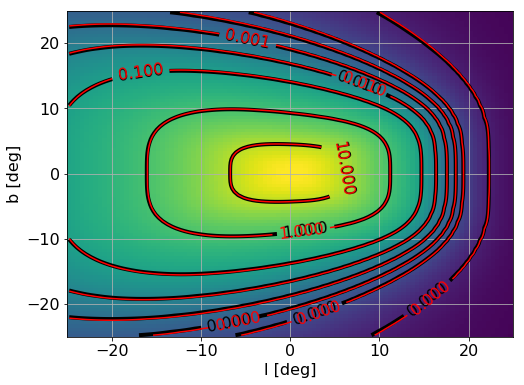

In [21]:
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,bb_normed,
               norm=colors.PowerNorm(0.1,vmin=bb_normed.min(),vmax=bb_normed.max()))
# power norm index 0.1 to compare the outskirts
cs2 = plt.contour(l,b,bb_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

cs1 = plt.contour(l,b,np.flip(bb_ts)*1e4,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
plt.clabel(cs1,cs1.levels)
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()

In [22]:
# looks decent

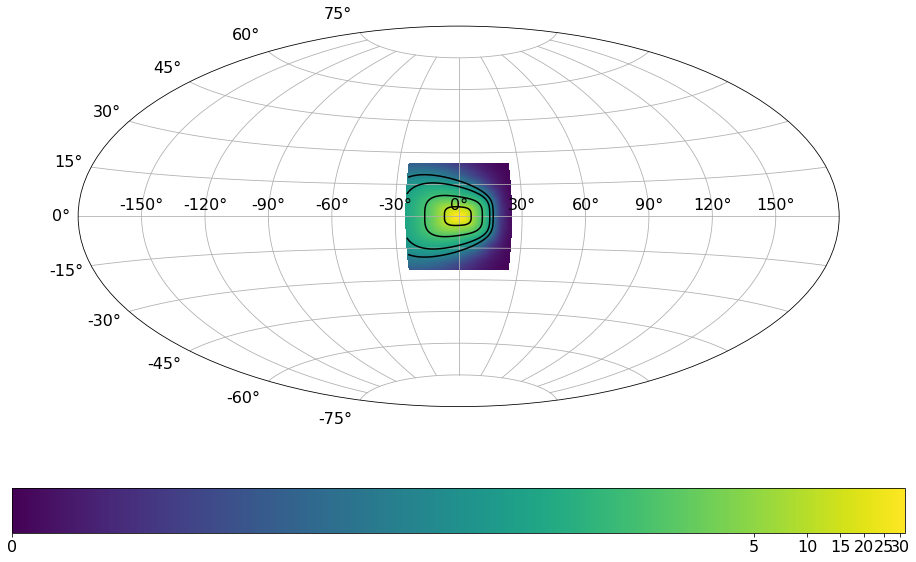

In [23]:
# in full sky
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
pl = plt.pcolormesh(np.deg2rad(L_ARRg),np.deg2rad(B_ARRg),bb_normed,
               norm=colors.PowerNorm(0.1,vmin=bb_normed.min(), vmax=bb_normed.max()),)
plt.contour(np.deg2rad(l),np.deg2rad(b),bb_normed,levels=[0.01,0.1,1,10,100,1000],colors='black')
plt.colorbar(pl,orientation='horizontal')
plt.grid()

Text(0.5, 0, 'b [deg]')

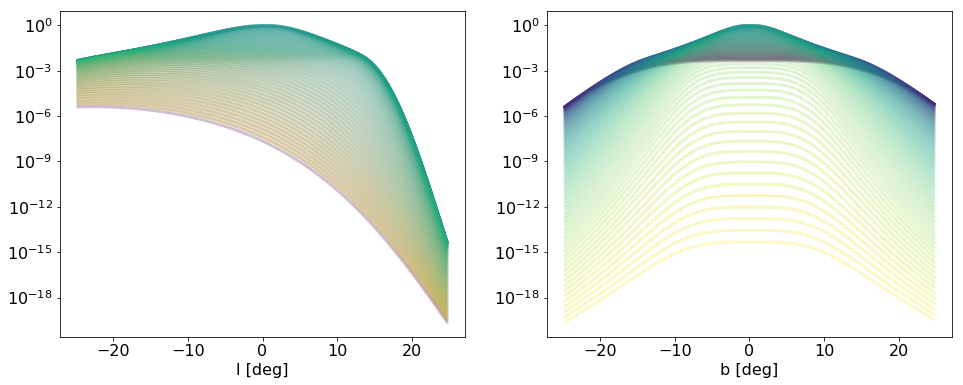

In [24]:
# plotting the profiles along lon and lat
plt.figure(figsize=(16,6))
plt.subplot(121)
for i in range(n_pixels):
    plt.semilogy(l,bb_normed[i,:]/np.amax(bb_normed),color=plt.cm.viridis(i/n_pixels),alpha=0.25,linewidth=3)
plt.xlabel('l [deg]')

plt.subplot(122)
for i in range(n_pixels):
    plt.semilogy(b,bb_normed[:,i]/np.amax(bb_normed),color=plt.cm.viridis(i/n_pixels),alpha=0.25,linewidth=3)
plt.xlabel('b [deg]')

# Gaussian smoothing

## with 2D map

In [25]:
from scipy.ndimage import gaussian_filter as smooth

In [26]:
# definition of smoothing values in units of the pixel size (0.5 deg)
# i.e. the range is from 0 (not smoothed) to 10*0.5 = 5 deg (right?)
smooth_arr = np.arange(0,10.25,0.25)

In [27]:
# make blurred test image and compare to previous ones
sf = 9 # ~ 1.125 deg, from best-fitting model (previous results)
bb_tmp = smooth(bb_normed,smooth_arr[sf],mode='nearest')
# I choose the nearest mode for extrapolating since it produces the least
# edge effects: in the previous approach, I used a larger image, smoothed that, and reduced it to 50x50 deg2

In [28]:
with fits.open('bulge_maps/Boxy_Bulge_50x50deg_Normalized_smoothfactor_'+str('%02i' %sf)+'.fits') as content:
    bb_ts_tmp = content[0].data

Text(0.5, 1.0, 'Smoothing factor 33')

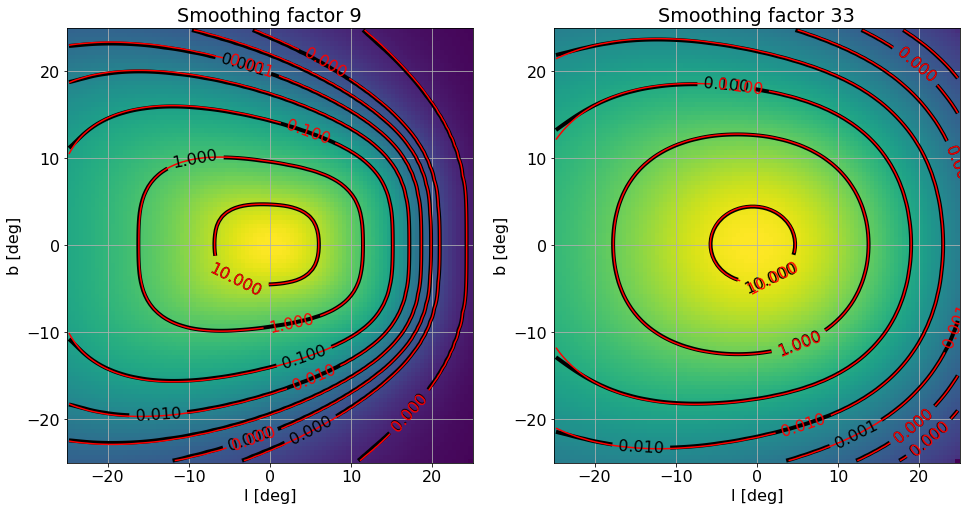

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(121)
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,bb_tmp,
               norm=colors.PowerNorm(0.1,vmin=bb_tmp.min(),vmax=bb_tmp.max()))
# power norm index 0.1 to compare the outskirts
cs2 = plt.contour(l,b,bb_tmp,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

cs1 = plt.contour(l,b,np.flip(bb_ts_tmp)*1e4,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
plt.clabel(cs1,cs1.levels)
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('Smoothing factor '+str(sf))

sf = 33 # ~ 4.125 deg, to have another example
bb_tmp = smooth(bb_normed,smooth_arr[sf],mode='nearest')
with fits.open('bulge_maps/Boxy_Bulge_50x50deg_Normalized_smoothfactor_'+str('%02i' %sf)+'.fits') as content:
    bb_ts_tmp = content[0].data
    
plt.subplot(122)
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,bb_tmp,
               norm=colors.PowerNorm(0.1,vmin=bb_tmp.min(),vmax=bb_tmp.max()))
# power norm index 0.1 to compare the outskirts
cs2 = plt.contour(l,b,bb_tmp,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

cs1 = plt.contour(l,b,np.flip(bb_ts_tmp)*1e4,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
plt.clabel(cs1,cs1.levels)
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('Smoothing factor '+str(sf))

In [30]:
# looks good. on the right, you can see that there is some effect on the very edge (l ~ -25)

Text(0.5, 0, 'b [deg]')

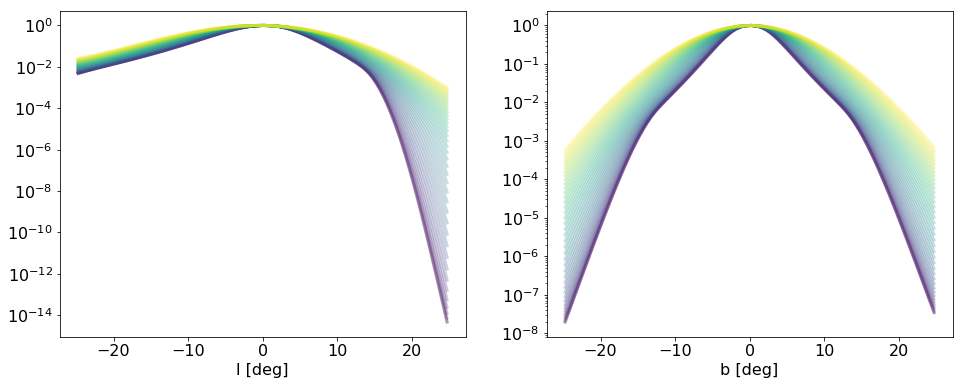

In [31]:
# plotting the profiles along lon and lat for all smoothing values
plt.figure(figsize=(16,6))
plt.subplot(121)
for sf in smooth_arr:
    bb_tmp = smooth(bb_normed,sf,mode='nearest')
    plt.semilogy(l,bb_tmp[50,:]/np.amax(bb_tmp),color=plt.cm.viridis(sf/smooth_arr.max()),alpha=0.25,linewidth=3)
plt.xlabel('l [deg]')

plt.subplot(122)
for sf in smooth_arr:
    bb_tmp = smooth(bb_normed,sf,mode='nearest')
    plt.semilogy(b,bb_tmp[:,50]/np.amax(bb_tmp),color=plt.cm.viridis(sf/smooth_arr.max()),alpha=0.25,linewidth=3)
plt.xlabel('b [deg]')


## with 3D bins

In [32]:
# define pixel size in 3D
# 5 pc will take for ever...
# test 100 pc ~ (xmax-xmin)/nx -> nx ~ 120, ny ~ 120, nz ~ 80
xmin,xmax = -6,6
ymin,ymax = -6,6
zmin,zmax = -4,4 # I think we doen need that much for z

# for testing coarser binning
scl = 1

nx = int(120/scl)
nxc = int(nx/2)
ny = int(120/scl)
nyc = int(ny/2)
nz = int(80/scl)
nzc = int(nz/2)
xg = np.linspace(xmin,xmax,nx+1)
yg = np.linspace(ymin,ymax,ny+1)
zg = np.linspace(zmin,zmax,nz+1)
x = (xg[1:]+xg[0:-1])/2
y = (yg[1:]+yg[0:-1])/2
z = (zg[1:]+zg[0:-1])/2

# define 3D volume element
dx = np.diff(xg)[0]
dy = np.diff(yg)[0]
dz = np.diff(zg)[0]
dV = dx*dy*dz

In [33]:
dx,dy,dz,dV

(0.09999999999999964,
 0.09999999999999964,
 0.10000000000000009,
 0.0009999999999999937)

In [34]:
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
xx.shape

(120, 120, 80)

In [35]:
f98bar = np.vectorize(F98bar)(xx,yy,zz)
f98bar.shape

(120, 120, 80)

Text(0, 0.5, 'Z [kpc]')

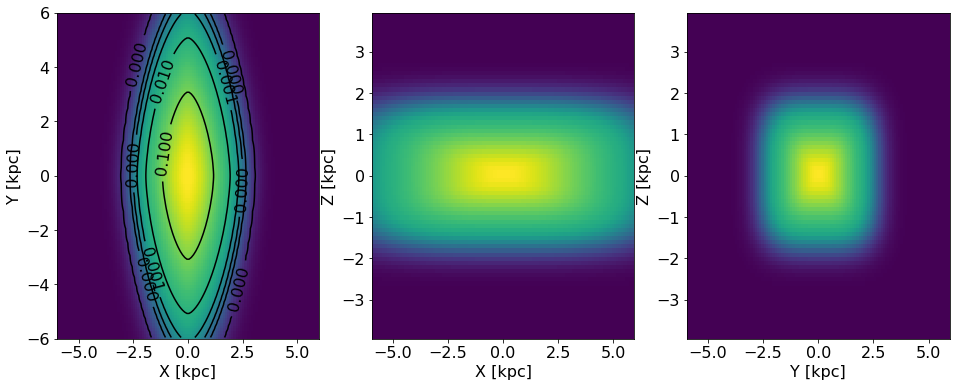

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].pcolormesh(xg,yg,f98bar[:,:,nzc],norm=colors.PowerNorm(0.1))
cs2 = axs[0].contour(x,y,f98bar[:,:,nzc],levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black')
plt.clabel(cs2,cs2.levels)
axs[0].set_xlabel('X [kpc]')
axs[0].set_ylabel('Y [kpc]')
axs[1].pcolormesh(x,z,f98bar[:,nyc,:].T,norm=colors.PowerNorm(0.1))
axs[1].set_xlabel('X [kpc]')
axs[1].set_ylabel('Z [kpc]')
axs[2].pcolormesh(y,z,f98bar[nxc,:,:].T,norm=colors.PowerNorm(0.1))
axs[2].set_xlabel('Y [kpc]')
axs[2].set_ylabel('Z [kpc]')

In [37]:
# again, outskirts would be cut off but beyond the 1e-3 level

Text(0.5, 0, 'Z [kpc]')

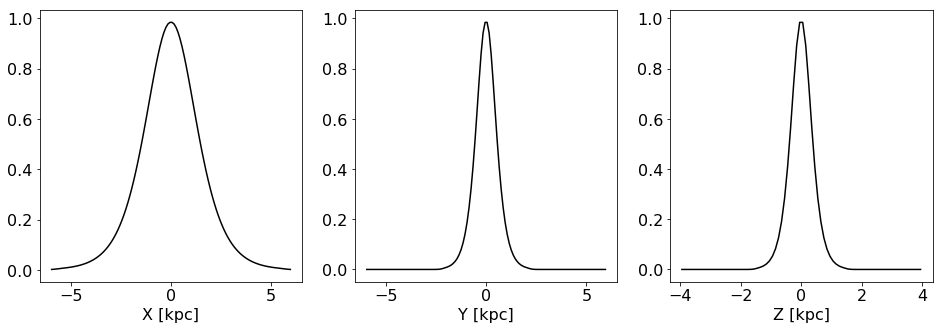

In [38]:
# profiles
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(x,f98bar[:,nyc,nzc])
axs[0].set_xlabel('X [kpc]')
axs[1].plot(y,f98bar[nxc,:,nzc])
axs[1].set_xlabel('Y [kpc]')
axs[2].plot(z,f98bar[nxc,nyc,:])
axs[2].set_xlabel('Z [kpc]')

In [39]:
# now blur in x/y/z direction with, say, 400 pc
# this translates to different scales in x/y/z pixels when they are not uniform
# in general: blur_scale / dx = pixel factor
blur_scale = 0.4 # kpc
bx = blur_scale/dx
by = blur_scale/dy
bz = blur_scale/dz
f98blur = smooth(f98bar,(bz,by,bz),mode='nearest')

[]

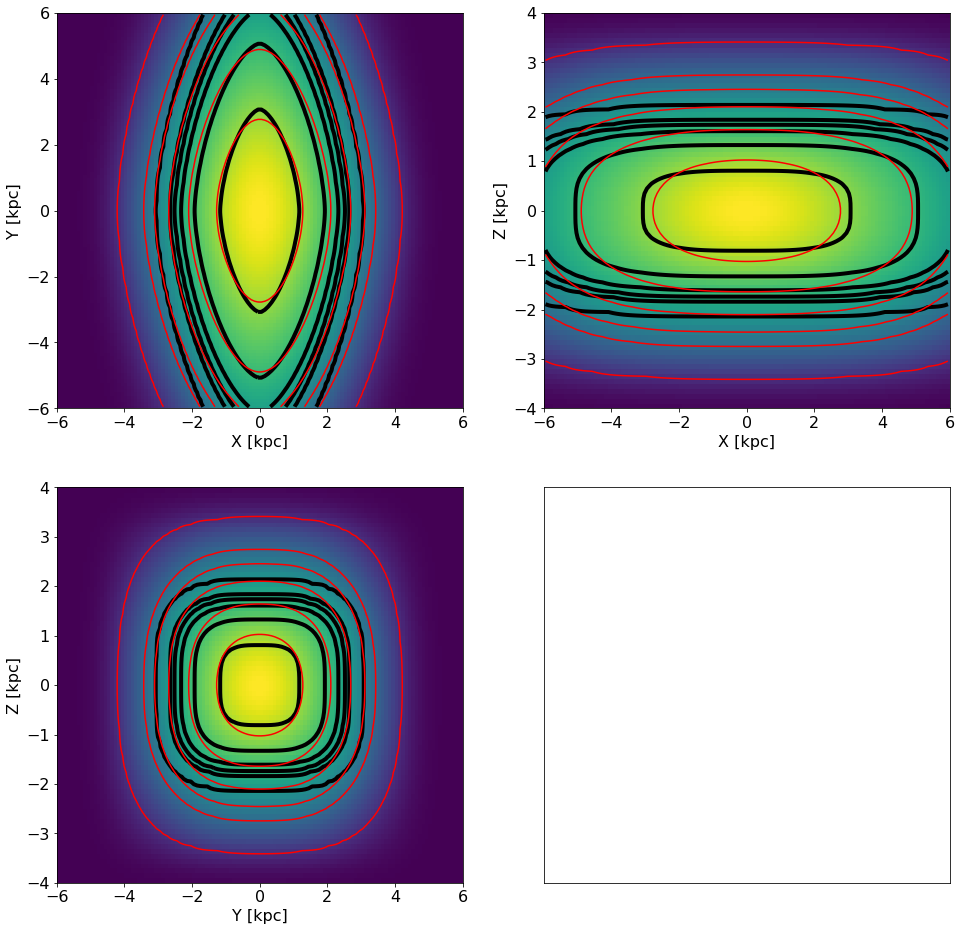

In [40]:
# comparison to before in all dimensions (black before, red after blurring)
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs[0,0].pcolormesh(xg,yg,f98blur[:,:,nzc],norm=colors.PowerNorm(0.1))
cs2 = axs[0,0].contour(x,y,f98bar[:,:,nzc],levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',
                     linewidths=4)
cs1 = axs[0,0].contour(x,y,f98blur[:,:,nzc],levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
axs[0,0].set_xlabel('X [kpc]')
axs[0,0].set_ylabel('Y [kpc]')

axs[0,1].pcolormesh(xg,zg,f98blur[:,nyc,:].T,norm=colors.PowerNorm(0.1))
cs2 = axs[0,1].contour(x,z,f98bar[:,nyc,:].T,levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',
                     linewidths=4)
cs1 = axs[0,1].contour(x,z,f98blur[:,nyc,:].T,levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
axs[0,1].set_xlabel('X [kpc]')
axs[0,1].set_ylabel('Z [kpc]')

axs[1,0].pcolormesh(xg,zg,f98blur[nxc,:,:].T,norm=colors.PowerNorm(0.1))
cs2 = axs[1,0].contour(x,z,f98bar[nxc,:,:].T,levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',
                     linewidths=4)
cs1 = axs[1,0].contour(x,z,f98blur[nxc,:,:].T,levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
axs[1,0].set_xlabel('Y [kpc]')
axs[1,0].set_ylabel('Z [kpc]')

axs[1,1].set_xticks([])
axs[1,1].set_yticks([])


(1e-06, 1)

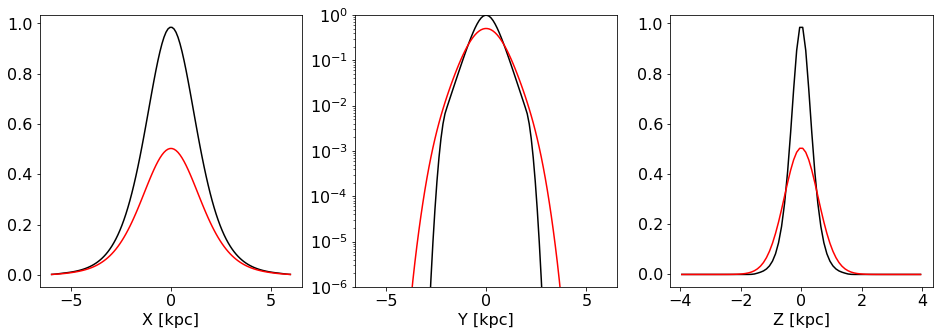

In [41]:
# profiles (black before, red after blurring)
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(x,f98bar[:,nyc,nzc])
axs[0].plot(x,f98blur[:,nyc,nzc])
axs[0].set_xlabel('X [kpc]')
axs[1].plot(y,f98bar[nxc,:,nzc])
axs[1].plot(y,f98blur[nxc,:,nzc])
axs[1].set_xlabel('Y [kpc]')
axs[2].plot(z,f98bar[nxc,nyc,:])
axs[2].plot(z,f98blur[nxc,nyc,:])
axs[2].set_xlabel('Z [kpc]')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-6,1)

In [42]:
# looks like a huge spread already with 400 pc?

# line of sight integral w/ interpolation

Having the NxNxN bins for the bar function and NxNxNx3 bins for the Cartisian coordinates, I want to estimate the bar function MxMxM for MxMxMx3 bins for the Galactic coordinates.  
First transform the Galactic coordinate to Cartisian coordinates, then use multidimensional interpolation to calculate the bar function.

In [43]:
def coord_trans(s,b,l):
    x0 = 8.5
    y0 = 0.0
    z0 = 0.01646
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    return x,y,z

## no blurring

In [44]:
# reshape values and points to Nx1 and Nx3 dimensions

In [45]:
values = np.vectorize(F98xyz)(xx,yy,zz)#.reshape(np.prod(xx.shape))
values.shape

(120, 120, 80)

In [46]:
from scipy.interpolate import RegularGridInterpolator

In [47]:
# this is not needed with the RegularGridInterpolator() function to quickly interpolate regular gridded data!
#points = np.stack((xx.reshape(np.prod(xx.shape)),
#                   yy.reshape(np.prod(xx.shape)),
#                   zz.reshape(np.prod(xx.shape)))).transpose()
#points.shape

In [48]:
# coordinate transformation of points which we chose before
xx_interp, yy_interp, zz_interp = coord_trans(grid_s,grid_b,grid_l)

In [49]:
# similar vector input as with griddata
xi = np.stack((xx_interp.reshape(np.prod(xx_interp.shape)),
               yy_interp.reshape(np.prod(xx_interp.shape)),
               zz_interp.reshape(np.prod(xx_interp.shape)))).transpose()

In [50]:
from time import time

In [51]:
start = time()
values_interp = RegularGridInterpolator((x,y,z), values, method='linear',bounds_error=False, fill_value=0)
end = time()
print(end-start)
# very fast

0.0002071857452392578


In [52]:
# reshape to gridded values from before
new_values = values_interp(xi).reshape(grid_s.shape)

In [53]:
#los = grid_s**2*cos(deg2rad*grid_b)*(values_interp.reshape(100,100,100)) # reshape to 100x100x100
los_new = new_values 

In [54]:
bb_interp = np.sum(los_new*ds,axis=0) # similar to before

In [55]:
bb_interp_normed = bb_interp / np.sum(bb_interp*domega) # normalise to 1

Text(0.5, 1.0, 'black = original; red = interpolated')

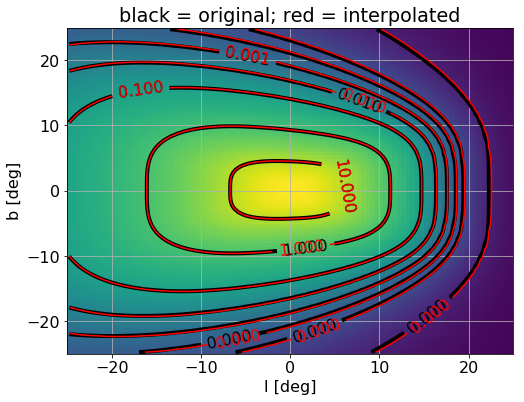

In [56]:
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,bb_interp_normed,
               norm=colors.PowerNorm(0.1,vmin=bb_interp_normed.min(),vmax=bb_interp_normed.max()))
# power norm index 0.1 to compare the outskirts
cs2 = plt.contour(l,b,bb_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

cs1 = plt.contour(l,b,bb_interp_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
plt.clabel(cs1,cs1.levels)
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('black = original; red = interpolated')

In [57]:
# not completely identical at the outskrits but way faster than my 2.5 hours from before
# so we can also increase the 3D-pixel size

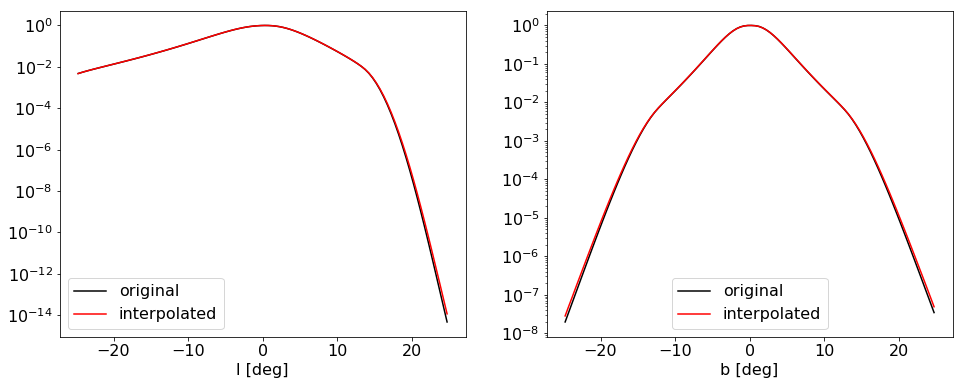

In [58]:
# plotting the profiles along lon and lat for all smoothing values
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.semilogy(l,bb_normed[npc,:]/np.amax(bb_normed),color='black',label='original')
plt.semilogy(l,bb_interp_normed[npc,:]/np.amax(bb_interp_normed),color='red',label='interpolated')
plt.xlabel('l [deg]')
plt.legend()

plt.subplot(122)
plt.semilogy(b,bb_normed[:,npc]/np.amax(bb_normed),color='black',label='original')
plt.semilogy(b,bb_interp_normed[:,npc]/np.amax(bb_interp_normed),color='red',label='interpolated')
plt.xlabel('b [deg]')
plt.legend()


In [59]:
# so this looks quite nice, and we came dow nto a few seconds for the interpolation step

## with blurring

In [60]:
bx,by,bz # blurring factors in units of dx,dy,dz ~ 100 pc

(4.000000000000014, 4.000000000000014, 3.999999999999997)

In [61]:
values_blur = smooth(np.vectorize(F98xyz)(xx,yy,zz),(bx,by,bz),mode='nearest')

In [62]:
values_blur.shape

(120, 120, 80)

In [63]:
values_blur_interp = RegularGridInterpolator((x,y,z), values_blur, method='linear',bounds_error=False, fill_value=0)

In [64]:
new_values_blur = values_blur_interp(xi).reshape(grid_s.shape)

In [65]:
los_new_blur = (new_values_blur) 

In [66]:
bb_interp_blur = np.sum(los_new_blur*ds,axis=0)

In [67]:
bb_interp_blur_normed = bb_interp_blur / np.sum(bb_interp_blur*domega) # normalise to 1

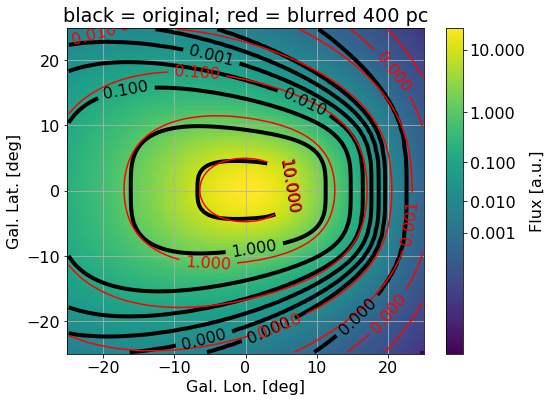

In [99]:
# compare contours
pcm = plt.pcolormesh(L_ARRg,B_ARRg,bb_interp_blur_normed,
               norm=colors.PowerNorm(0.1,vmin=bb_interp_blur_normed.min(),vmax=bb_interp_blur_normed.max()))
plt.colorbar(pcm,ticks=[0.001,0.01,0.1,1,10],label='Flux [a.u.]')
# power norm index 0.1 to compare the outskirts
cs2 = plt.contour(l,b,bb_interp_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

cs1 = plt.contour(l,b,bb_interp_blur_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
plt.clabel(cs1,cs1.levels)
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid()
plt.title('black = original; red = blurred 400 pc')

plt.savefig('BB_blur_comparison400pc.pdf')

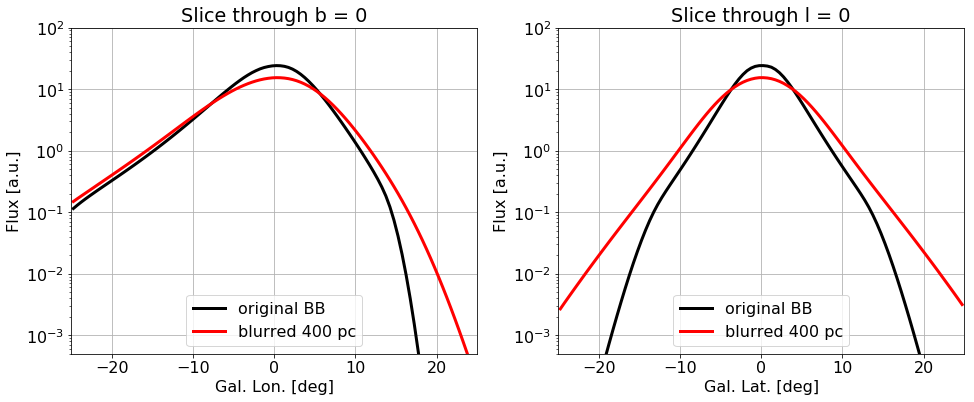

In [101]:
# plotting the profiles along lon and lat for all smoothing values
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.semilogy(l,bb_interp_normed[npc,:]/np.mean(bb_interp_normed),
             color='black',label='original BB',linewidth=3)
plt.semilogy(l,bb_interp_blur_normed[npc,:]/np.mean(bb_interp_blur_normed),
             color='red',label='blurred 400 pc',linewidth=3)
plt.xlabel('Gal. Lon. [deg]')
plt.legend(loc=8)
plt.grid()
plt.title('Slice through b = 0')
plt.ylim(5e-4,1e2)
plt.xlim(-25,25)
plt.ylabel('Flux [a.u.]')

plt.subplot(122)
plt.semilogy(b,bb_interp_normed[:,npc]/np.mean(bb_interp_normed),
             color='black',label='original BB',linewidth=3)
plt.semilogy(b,bb_interp_blur_normed[:,npc]/np.mean(bb_interp_blur_normed),
             color='red',label='blurred 400 pc',linewidth=3)
plt.xlabel('Gal. Lat. [deg]')
plt.title('Slice through l = 0')
plt.legend(loc=8)
plt.ylim(5e-4,1e2)
plt.grid()
plt.xlim(-25,25)
plt.xlim(-25,25)
plt.ylabel('Flux [a.u.]')

plt.savefig('BB_blur_comparison400pc_slices.pdf')

(-25, 25)

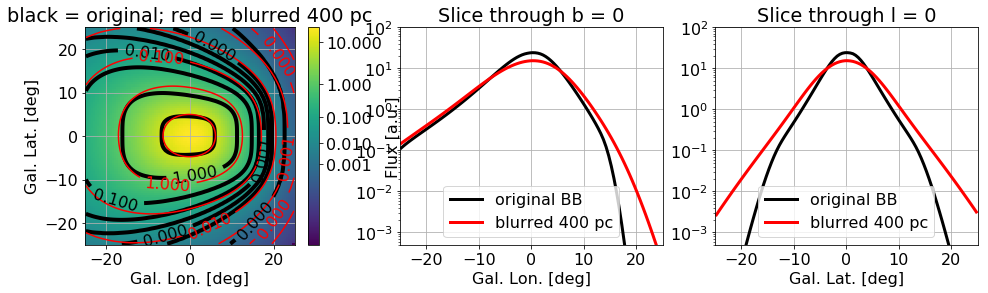

In [98]:
plt.figure(figsize=(16,4))

plt.subplot(131)
# compare contours
pcm = plt.pcolormesh(L_ARRg,B_ARRg,bb_interp_blur_normed,
               norm=colors.PowerNorm(0.1,vmin=bb_interp_blur_normed.min(),vmax=bb_interp_blur_normed.max()))
plt.colorbar(pcm,ticks=[0.001,0.01,0.1,1,10],label='Flux [a.u.]')
# power norm index 0.1 to compare the outskirts
cs2 = plt.contour(l,b,bb_interp_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

cs1 = plt.contour(l,b,bb_interp_blur_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
plt.clabel(cs1,cs1.levels)
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid()
plt.title('black = original; red = blurred 400 pc')

# plotting the profiles along lon and lat for all smoothing values
plt.subplot(132)
plt.semilogy(l,bb_interp_normed[npc,:]/np.mean(bb_interp_normed),
             color='black',label='original BB',linewidth=3)
plt.semilogy(l,bb_interp_blur_normed[npc,:]/np.mean(bb_interp_blur_normed),
             color='red',label='blurred 400 pc',linewidth=3)
plt.xlabel('Gal. Lon. [deg]')
plt.legend(loc=8)
plt.grid()
plt.title('Slice through b = 0')
plt.ylim(5e-4,1e2)
plt.xlim(-25,25)

plt.subplot(133)
plt.semilogy(b,bb_interp_normed[:,npc]/np.mean(bb_interp_normed),
             color='black',label='original BB',linewidth=3)
plt.semilogy(b,bb_interp_blur_normed[:,npc]/np.mean(bb_interp_blur_normed),
             color='red',label='blurred 400 pc',linewidth=3)
plt.xlabel('Gal. Lat. [deg]')
plt.title('Slice through l = 0')
plt.legend(loc=8)
plt.ylim(5e-4,1e2)
plt.grid()
plt.xlim(-25,25)

In [67]:
# save files for range of physical length scales
flux_norm = 1e-4
blur_scale_arr = np.arange(0,0.625,0.025) # kpc

In [68]:
blur_scale_arr

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  ])

In [69]:
dx,dy,dz

(0.09999999999999964, 0.09999999999999964, 0.10000000000000009)

In [70]:
from astropy import wcs
wcs = wcs.WCS(naxis=2)
nx = 100
ny = 100
pixscalelon = 0.5 # cdelt1
pixscalelat = 0.5  # cdelt2

small = np.where((np.abs(L_ARR) < 25) & (np.abs(B_ARR) < 25))

wcs.wcs.crpix = [51, 51] # Ref pixel for axis 1 and 2
wcs.wcs.cdelt = np.array([pixscalelon, pixscalelat]) # what is the pixel scale in lon, lat.
wcs.wcs.crval = [0,0] #[0.25,-0.25] #what is the galactic coordinate of that pixel.
wcs.wcs.ctype = ["GLON-CAR", "GLAT-CAR"] #CAR projection #AIT projection

In [71]:
import datetime
today = datetime.date.today()

In [1116]:
# loop over smoothing factors for BB template
for i in tqdm(range(len(blur_scale_arr))):
    # calculate smoothed templated in 3D
    blur_scale_tmp = blur_scale_arr[i] # kpc
    bx = blur_scale_tmp/dx
    by = blur_scale_tmp/dy
    bz = blur_scale_tmp/dz
    values_blur = smooth(np.vectorize(F98xyz)(xx,yy,zz),(bx,by,bz),mode='nearest')
    values_blur_interp = RegularGridInterpolator((x,y,z),values_blur,
                                                 method='linear',bounds_error=False,fill_value=0)
    new_values_blur = values_blur_interp(xi).reshape(grid_s.shape)
    los_new_blur = (new_values_blur) 
    bb_interp_blur = np.sum(los_new_blur*ds,axis=0)

    # normalise to 1e-4
    bb_tmp = bb_interp_blur / np.sum(bb_interp_blur*domega)*flux_norm
    
    # write wcs to fits header
    header = wcs.to_header()
    header['history'] = "Thomas Siegert [tsiegert@ucsd.edu] created this file on "+str(today)+" " 

    # define header
    hdu = fits.PrimaryHDU(np.flip(bb_tmp),header=header)
    
    # save file
    hdu.writeto('bulge_maps/Boxy_Bulge_50x50deg_Normalized_3D_smoothfactor_'+str('%02i' % i)+'.fits', overwrite=True)

In [1117]:
bx,by,bz

(6.000000000000022, 6.000000000000022, 5.999999999999996)

<h3>Now for NB:<br>
    Using a 3D Gaussian to describe rebinned NB component (from "make_blurred_bulges.ipynb")</h3>

In [72]:
# read in unsmoothed but rebinned version:

with fits.open('bulge_maps/Stellar_profile_Normalized_smoothfactor_'+str('%02i' % 0)+'.fits') as content:
    nb_ts = content[0].data

Text(0.5, 1.0, 'Smoothing factor 10.0')

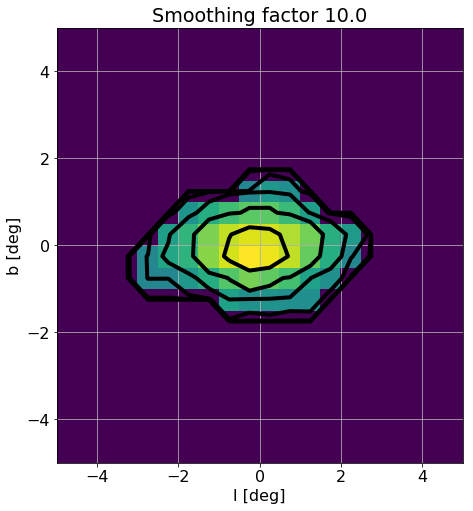

In [73]:
plt.figure(figsize=(16,8))
plt.subplot(121)
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,nb_ts,
               norm=colors.PowerNorm(0.1,vmin=nb_ts.min(),vmax=nb_ts.max()))
# power norm index 0.1 to compare the outskirts
cs2 = plt.contour(l,b,nb_ts,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('Smoothing factor '+str(sf))

<h5>Parametrised with Bartels+2018 model of NB=NSC+NSD</h5>

In [74]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
@jit(nopython=True)
def NSC3Dgal(s,b,l):
    x0 = 8.5
    y0 = 0
    z0 = 0.01646
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    rho0 = 3.3e6
    rho1 = 89.88e6
    phi = 13.79*deg2rad
    theta = 0*deg2rad
    R0 = 0.00022
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp = sqrt(xp**2+yp**2+zp**2)
    
    Rin = 0.006
    Rout = 0.2
    
    if (Rp <= Rin):
        return rho0/(1+(Rp/R0)**2)
    elif (Rp > Rin) & (Rp <= Rout):
        return rho1/(1+(Rp/R0)**3)
    else:
        return 0.

In [75]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
@jit(nopython=True)
def NSC3Dxyz(x,y,z):
    rho0 = 3.3e6
    rho1 = 89.88e6
    phi = 13.79*deg2rad
    theta = 0*deg2rad
    R0 = 0.00022
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp = sqrt(xp**2+yp**2+zp**2)
    
    Rin = 0.006
    Rout = 0.2

    if (Rp <= Rin):
        return rho0/(1+(Rp/R0)**2)
    elif (Rp > Rin) & (Rp <= Rout):
        return rho1/(1+(Rp/R0)**3)
    else:
        return 0.

In [76]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
@jit(nopython=True)
def NSD3Dgal(s,b,l):
    x0 = 8.5
    y0 = 0
    z0 = 0.01646
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    rho0 = 301.
    rho1 = 11.73e6
    rho2 = 5.94e24
    phi = 13.79*deg2rad
    theta = 0*deg2rad
    R0 = 0.001
    zscl = 0.030 # slight decrease wrt to paper values as NB template is squezed in latitude
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp = sqrt(xp**2+yp**2)
    
    Rs = np.sqrt(Rp**2+zp**2)
    
    Rin = 0.12
    Rout = 0.22
    Rmax = 0.5
    # define cuts in R and z to be more conform with NB template
    Rscut = 0.35
    zcut = 0.35
    
    if fabs(zp) <= zcut: 
        if (Rp <= Rin):
            return rho0*(Rp/R0)**(-0.1)*exp(-fabs(zp/zscl))*exp(-(Rs-Rscut)**2/Rscut**2)
        elif (Rp > Rin) & (Rp <= Rout):
            return rho1*(Rp/R0)**(-3.5)*exp(-fabs(zp/zscl))*exp(-(Rs-Rscut)**2/Rscut**2)
        elif (Rp > Rout) & (Rp <= Rmax):
            return rho2*(Rp/R0)**(-10.0)*exp(-fabs(zp/zscl))*exp(-(Rs-Rscut)**2/Rscut**2)
        else:
            return 0
    else:
        return 0

In [77]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
@jit(nopython=True)
def NSD3Dxyz(x,y,z):
    rho0 = 301.
    rho1 = 11.73e6
    rho2 = 5.94e24
    phi = 13.79*deg2rad
    theta = 0*deg2rad
    R0 = 0.001
    zscl = 0.030
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp = sqrt(xp**2+yp**2)
    
    Rs = np.sqrt(Rp**2+zp**2)
    
    Rin = 0.12
    Rout = 0.22
    Rmax = 0.5
    # define cuts in R and z to be more conform with NB template
    Rscut = 0.35
    zcut = 0.35
    
    if fabs(zp) <= zcut: 
        if (Rp <= Rin):
            return rho0*(Rp/R0)**(-0.1)*exp(-fabs(zp/zscl))*exp(-(Rs-Rscut)**2/Rscut**2)
        elif (Rp > Rin) & (Rp <= Rout):
            return rho1*(Rp/R0)**(-3.5)*exp(-fabs(zp/zscl))*exp(-(Rs-Rscut)**2/Rscut**2)
        elif (Rp > Rout) & (Rp <= Rmax):
            return rho2*(Rp/R0)**(-10.0)*exp(-fabs(zp/zscl))*exp(-(Rs-Rscut)**2/Rscut**2)
        else:
            return 0
    else:
        return 0

In [78]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
# add both components
@jit(nopython=True)
def NB3Dgal(s,b,l):
    return NSC3Dgal(s,b,l) + NSD3Dgal(s,b,l)

In [79]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
# add both components
@jit(nopython=True)
def NB3Dxyz(x,y,z):
    return NSC3Dxyz(x,y,z) + NSD3Dxyz(x,y,z)

<h5>Redefine integration scale for NB as everything happens inside 1 kpc around the centre:</h5>

In [80]:
# define pixel size in 3D
# test 10 pc ~ (xmax-xmin)/nx -> nx ~ 200, ny ~ 200, nz ~ 200
# for blurring a larger range is needed (0 otherwise)
xmin,xmax = -6,6
ymin,ymax = -6,6
zmin,zmax = -4,4

# for testing coarser binning
scl = 1

nx = int(240/scl)
nxc = int(nx/2)
ny = int(240/scl)
nyc = int(ny/2)
nz = int(160/scl)
nzc = int(nz/2)
xg = np.linspace(xmin,xmax,nx+1)
yg = np.linspace(ymin,ymax,ny+1)
zg = np.linspace(zmin,zmax,nz+1)
x = (xg[1:]+xg[0:-1])/2
y = (yg[1:]+yg[0:-1])/2
z = (zg[1:]+zg[0:-1])/2

# define 3D volume element
dx = np.diff(xg)[0]
dy = np.diff(yg)[0]
dz = np.diff(zg)[0]
dV = dx*dy*dz
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')


In [81]:
# definition of image space

# minmax range for our data set is ~25 deg in lon and lat
lmin,lmax = -25,25
bmin,bmax = -25,25

# SPI resolution is ~2.5 deg, here we oversample the resolution
binsize = 0.5
n_pixels = 100
npc = int(n_pixels/2)

# range for line of sight integration only important near galactic centre
# will be very close to zero outside 6 kpc radius from centre
# the value 6 kpc is empirical; the outskirts around 20 deg require also the very wide values
srange = 6.
smin,smax = x0-srange,x0+srange

# use resolutin of 5 pc = 2ds / n_los_steps ~ 400
# also here driven empirical to get values from exact integration
n_los_steps = 400

# define lon, lat, and los arrays, with and without boundaries
s = np.linspace(smin,smax,n_los_steps)
ds = np.diff(s)[0] # los element
bg = np.linspace(bmin,bmax,n_pixels+1)
lg = np.linspace(lmin,lmax,n_pixels+1)
b = (bg[1:]+bg[0:-1])/2
l = (lg[1:]+lg[0:-1])/2

# define 2D meshgrid for image coordinates
L_ARRg, B_ARRg = np.meshgrid(lg,bg)
L_ARR, B_ARR = np.meshgrid(l,b)

# define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))
# meshgrid for 3D space: image-los
grid_s, grid_b, grid_l = np.meshgrid(s,b,l,indexing="ij")

In [82]:
def coord_trans(s,b,l):
    x0 = 8.5
    y0 = 0.0
    z0 = -0.005 # slight adaption to have more wight on b<0 pixels
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    return x,y,z

In [83]:
# coordinate transformation of points which we chose before
xx_interp, yy_interp, zz_interp = coord_trans(grid_s,grid_b,grid_l)
# similar vector input as with griddata
xi = np.stack((xx_interp.reshape(np.prod(xx_interp.shape)),
               yy_interp.reshape(np.prod(xx_interp.shape)),
               zz_interp.reshape(np.prod(xx_interp.shape)))).transpose()

In [84]:
dx,dy,dz,dV

(0.04999999999999982,
 0.04999999999999982,
 0.04999999999999982,
 0.00012499999999999867)

In [85]:
z0

0.01646

In [86]:
values_nbpar = np.vectorize(NB3Dxyz)(xx,yy,zz)
values_nbpar.shape
values_nbpar_interp = RegularGridInterpolator((x,y,z), values_nbpar, method='linear',bounds_error=False, fill_value=0)
new_values_nbpar = values_nbpar_interp(xi).reshape(grid_s.shape)
los_new_nbpar = cos(deg2rad*grid_b)*(new_values_nbpar) 
nbpar_interp = np.sum(los_new_nbpar*ds,axis=0)
nbpar_interp_normed = nbpar_interp / np.sum(nbpar_interp*domega) # normalise to 1

Text(0.5, 1.0, 'nbpar test')

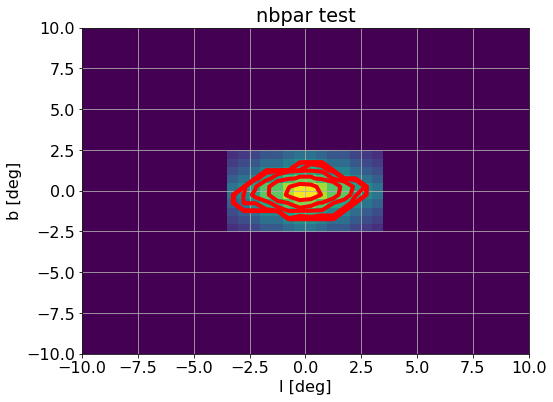

In [87]:
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,nbpar_interp_normed,
               norm=colors.PowerNorm(0.1,vmin=nbpar_interp_normed.min(),vmax=nbpar_interp_normed.max()))
# power norm index 0.1 to compare the outskirts



"""cs2 = plt.contour(l,b,nbpar_interp_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)"""

cs2 = plt.contour(l,b,nb_ts,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red',linewidths=4)
plt.clabel(cs2,cs2.levels)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('nbpar test')

<h5>Residuals</h5>

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(-5, 5)

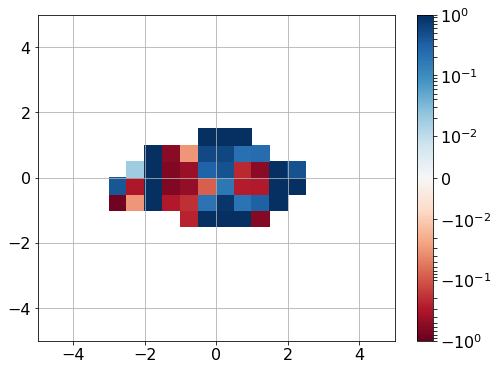

In [88]:
plt.pcolormesh(L_ARRg,B_ARRg,(nbpar_interp_normed*1e-4-nb_ts)/(nb_ts),
               cmap=plt.cm.RdBu,norm=colors.SymLogNorm(1e-2),vmin=-1,vmax=1)
plt.grid()
plt.colorbar()
plt.xlim(-5,5)
plt.ylim(-5,5)

In [89]:
# saving files for smooth NB templates

In [90]:
i = 20
blur_scale_tmp = blur_scale_arr[i] # kpc
bx = blur_scale_tmp/dx
by = blur_scale_tmp/dy
bz = blur_scale_tmp/dz

In [91]:
values_blur = smooth(np.vectorize(NB3Dxyz)(xx,yy,zz),(bx,by,bz),mode='wrap')
values_blur_interp = RegularGridInterpolator((x,y,z),values_blur,
                                             method='linear',bounds_error=False,fill_value=0)
new_values_blur = values_blur_interp(xi).reshape(grid_s.shape)
los_new_blur = cos(deg2rad*grid_b)*(new_values_blur) 
nb_interp_blur = np.sum(los_new_blur*ds,axis=0)

# normalise to 1e-4
nb_tmp = nb_interp_blur / np.sum(nb_interp_blur*domega)*flux_norm

In [92]:
values_blur.shape

(240, 240, 160)

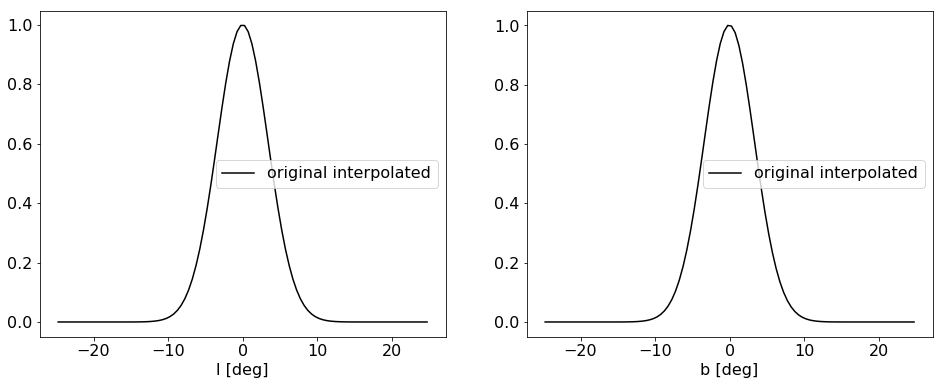

In [93]:
# plotting the profiles along lon and lat for all smoothing values
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(l,nb_tmp[npc,:]/np.amax(nb_tmp),color='black',label='original interpolated')
#plt.semilogy(l,bb_interp_blur_normed[npc,:]/np.amax(bb_interp_blur_normed),color='red',label='blurred interpolated')
plt.xlabel('l [deg]')
plt.legend()

plt.subplot(122)
plt.plot(b,nb_tmp[:,npc]/np.amax(nb_tmp),color='black',label='original interpolated')
#plt.semilogy(b,bb_interp_blur_normed[:,npc]/np.amax(bb_interp_blur_normed),color='red',label='blurred interpolated')
plt.xlabel('b [deg]')
plt.legend()




(1e-06, 1)

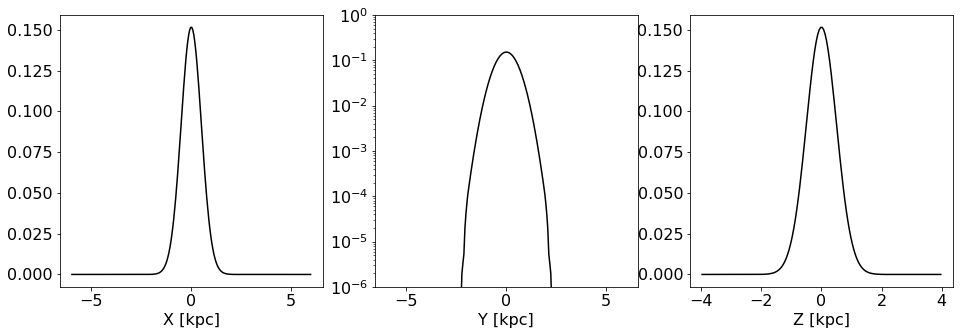

In [96]:
# profiles (black before, red after blurring)
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(x,values_blur[:,nyc,nzc])
#axs[0].plot(x,f98blur[:,nyc,nzc])
axs[0].set_xlabel('X [kpc]')
axs[1].plot(y,values_blur[nxc,:,nzc])
#axs[1].plot(y,f98blur[nxc,:,nzc])
axs[1].set_xlabel('Y [kpc]')
axs[2].plot(z,values_blur[nxc,nyc,:])
#axs[2].plot(z,f98blur[nxc,nyc,:])
axs[2].set_xlabel('Z [kpc]')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-6,1)

Text(0.5, 1.0, 'NB test: black = true, red = test')

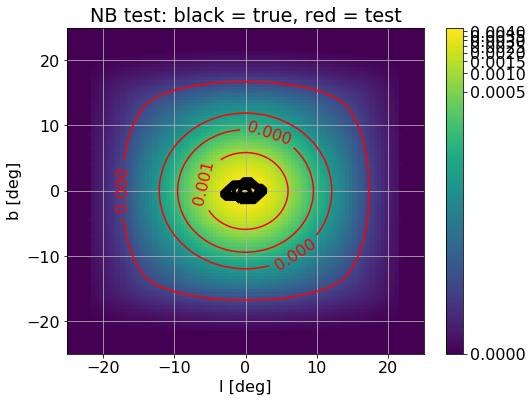

In [97]:
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,nb_tmp,
               norm=colors.PowerNorm(0.1,vmin=nb_tmp.min(),vmax=nb_tmp.max()))
plt.colorbar()
# power norm index 0.1 to compare the outskirts



cs2 = plt.contour(l,b,nb_ts,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

cs1 = plt.contour(l,b,nb_tmp,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
plt.clabel(cs1,cs1.levels)
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('NB test: black = true, red = test')

In [98]:
# loop over smoothing factors for nb template
for i in tqdm(range(len(blur_scale_arr))):
    # calculate smoothed templated in 3D
    blur_scale_tmp = blur_scale_arr[i] # kpc
    bx = blur_scale_tmp/dx
    by = blur_scale_tmp/dy
    bz = blur_scale_tmp/dz
    values_blur = smooth(np.vectorize(NB3Dxyz)(xx,yy,zz),(bx,by,bz),mode='nearest')
    values_blur_interp = RegularGridInterpolator((x,y,z),values_blur,
                                                 method='linear',bounds_error=False,fill_value=0)
    new_values_blur = values_blur_interp(xi).reshape(grid_s.shape)
    los_new_blur = cos(deg2rad*grid_b)*(new_values_blur) 
    nb_interp_blur = np.sum(los_new_blur*ds,axis=0)

    # normalise to 1e-4
    nb_tmp = nb_interp_blur / np.sum(nb_interp_blur*domega)*flux_norm
    
    # write wcs to fits header
    header = wcs.to_header()
    header['history'] = "Thomas Siegert [tsiegert@ucsd.edu] created this file on "+str(today)+" " 

    # define header
    hdu = fits.PrimaryHDU(np.flip(nb_tmp),header=header)
    
    # save file
    hdu.writeto('bulge_maps/Stellar_profile_Normalized_3D_smoothfactor_'+str('%02i' % i)+'.fits', overwrite=True)

In [1144]:
blur_scale_arr/dx

array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
       27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5,
       55. , 57.5, 60. ])

In [99]:
n = np.zeros((19,120000))

In [109]:
n.size

2280000

In [108]:
print("%d Megabytes" % (n.size * n.itemsize / 1024 / 1024))

17 Megabytes


In [ ]:
def rho_NFW(r,rho0,alpha,beta,gamma,R0):
    rho_dm = 8e-3 # e.g. 1404.1938. in units of Msun / pc^3
    rho_dm_err = 3e-3 # uncertainty for rho_dm
    alpha = 1.
    beta = 3.
    gamma = 1.2
    R0 = 20e3
    return rho0/((r/R0)**gamma * (1 + (r/R0)**alpha)**((beta-gamma)/alpha))

In [247]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
@jit(nopython=True)
def NFW3Dgal(s,b,l):
    x0 = 8.5
    y0 = 0
    z0 = 0.01646
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    phi = 0.
    theta = 0.
    rho_dm = 8e-3 # e.g. 1404.1938. in units of Msun / pc^3
    rho_dm_err = 3e-3 # uncertainty for rho_dm
    alpha = 1.
    beta = 3.
    gamma = 1.2
    R0 = 20e3
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp = sqrt(xp**2+yp**2+zp**2)
    return (rho_dm/((Rp/R0)**gamma * (1 + (Rp/R0)**alpha)**((beta-gamma)/alpha)))**2

In [248]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
@jit(nopython=True)
def NFW3Dxyz(x,y,z):
    phi = 0.
    theta = 0.
    rho_dm = 8e-3 # e.g. 1404.1938. in units of Msun / pc^3
    rho_dm_err = 3e-3 # uncertainty for rho_dm
    alpha = 1.
    beta = 3.
    gamma = 1.2
    R0 = 20e3
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp = sqrt(xp**2+yp**2+zp**2)
    return (rho_dm/((Rp/R0)**gamma * (1 + (Rp/R0)**alpha)**((beta-gamma)/alpha)))**2

In [249]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
@jit(nopython=True)
def NFW0_3Dgal(s,b,l):
    x0 = 8.5
    y0 = 0
    z0 = 0.01646
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    phi = 0.
    theta = 0.
    rho_dm = 8e-3 # e.g. 1404.1938. in units of Msun / pc^3
    rho_dm_err = 3e-3 # uncertainty for rho_dm
    alpha = 1.
    beta = 3.
    gamma = 1.0
    R0 = 20e3
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp = sqrt(xp**2+yp**2+zp**2)
    return (rho_dm/((Rp/R0)**gamma * (1 + (Rp/R0)**alpha)**((beta-gamma)/alpha)))**2

In [250]:
# define 3D NB in s,l,b and x,y,z as sum of NSC and NSD
@jit(nopython=True)
def NFW0_3Dxyz(x,y,z):
    phi = 0.
    theta = 0.
    rho_dm = 8e-3 # e.g. 1404.1938. in units of Msun / pc^3
    rho_dm_err = 3e-3 # uncertainty for rho_dm
    alpha = 1.
    beta = 3.
    gamma = 1.0
    R0 = 20e3
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp = sqrt(xp**2+yp**2+zp**2)
    return (rho_dm/((Rp/R0)**gamma * (1 + (Rp/R0)**alpha)**((beta-gamma)/alpha)))**2

In [251]:
# define pixel size in 3D
# test 10 pc ~ (xmax-xmin)/nx -> nx ~ 200, ny ~ 200, nz ~ 200
# for blurring a larger range is needed (0 otherwise)
xmin,xmax = -6,6
ymin,ymax = -6,6
zmin,zmax = -6,6

# for testing coarser binning
scl = 1

nx = int(200/scl)
nxc = int(nx/2)
ny = int(200/scl)
nyc = int(ny/2)
nz = int(200/scl)
nzc = int(nz/2)
xg = np.linspace(xmin,xmax,nx+1)
yg = np.linspace(ymin,ymax,ny+1)
zg = np.linspace(zmin,zmax,nz+1)
x = (xg[1:]+xg[0:-1])/2
y = (yg[1:]+yg[0:-1])/2
z = (zg[1:]+zg[0:-1])/2

# define 3D volume element
dx = np.diff(xg)[0]
dy = np.diff(yg)[0]
dz = np.diff(zg)[0]
dV = dx*dy*dz
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')



In [252]:
# definition of image space

# minmax range for our data set is ~25 deg in lon and lat
lmin,lmax = -25,25
bmin,bmax = -25,25

# SPI resolution is ~2.5 deg, here we oversample the resolution
binsize = 0.5
n_pixels = 100
npc = int(n_pixels/2)

# range for line of sight integration only important near galactic centre
# will be very close to zero outside 6 kpc radius from centre
# the value 6 kpc is empirical; the outskirts around 20 deg require also the very wide values
srange = x0
smin,smax = x0-srange,x0+srange

# use resolutin of 5 pc = 2ds / n_los_steps ~ 400
# also here driven empirical to get values from exact integration
n_los_steps = 400

# define lon, lat, and los arrays, with and without boundaries
s = np.linspace(smin,smax,n_los_steps)
ds = np.diff(s)[0] # los element
bg = np.linspace(bmin,bmax,n_pixels+1)
lg = np.linspace(lmin,lmax,n_pixels+1)
b = (bg[1:]+bg[0:-1])/2
l = (lg[1:]+lg[0:-1])/2

# define 2D meshgrid for image coordinates
L_ARRg, B_ARRg = np.meshgrid(lg,bg)
L_ARR, B_ARR = np.meshgrid(l,b)

# define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))
# meshgrid for 3D space: image-los
grid_s, grid_b, grid_l = np.meshgrid(s,b,l,indexing="ij")

In [253]:
def coord_trans(s,b,l):
    x0 = 8.5
    y0 = 0.0
    z0 = 0.01646 # slight adaption to have more wight on b<0 pixels
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    return x,y,z

In [254]:
# coordinate transformation of points which we chose before
xx_interp, yy_interp, zz_interp = coord_trans(grid_s,grid_b,grid_l)
# similar vector input as with griddata
xi = np.stack((xx_interp.reshape(np.prod(xx_interp.shape)),
               yy_interp.reshape(np.prod(xx_interp.shape)),
               zz_interp.reshape(np.prod(xx_interp.shape)))).transpose()

In [255]:
i = 0
blur_scale_tmp = blur_scale_arr[i] # kpc
bx = blur_scale_tmp/dx
by = blur_scale_tmp/dy
bz = blur_scale_tmp/dz

In [256]:
blur_scale_arr_nfw = blur_scale_arr[::4]

In [257]:
blur_scale_tmp = blur_scale_arr_nfw[0] # kpc
bx = blur_scale_tmp/dx
by = blur_scale_tmp/dy
bz = blur_scale_tmp/dz
values_blur = smooth(np.vectorize(NFW0_3Dxyz)(xx,yy,zz),(bx,by,bz),mode='wrap')
values_blur_interp = RegularGridInterpolator((x,y,z),values_blur,
                                             method='linear',bounds_error=False,fill_value=0)
new_values_blur = values_blur_interp(xi).reshape(grid_s.shape)
los_new_blur = cos(deg2rad*grid_b)*(new_values_blur) 
nb_interp_blur = np.sum(los_new_blur*ds,axis=0)

# normalise to 1e-4
nfw0_tmp = nb_interp_blur / np.sum(nb_interp_blur*domega)*flux_norm

In [258]:
nfw12_arr = np.zeros((n_pixels,n_pixels,len(blur_scale_arr_nfw)))

for i in tqdm(range(len(blur_scale_arr_nfw))):
    blur_scale_tmp = blur_scale_arr_nfw[i] # kpc
    bx = blur_scale_tmp/dx
    by = blur_scale_tmp/dy
    bz = blur_scale_tmp/dz
    values_blur = smooth(np.vectorize(NFW3Dxyz)(xx,yy,zz),(bx,by,bz),mode='wrap')
    values_blur_interp = RegularGridInterpolator((x,y,z),values_blur,
                                                 method='linear',bounds_error=False,fill_value=0)
    new_values_blur = values_blur_interp(xi).reshape(grid_s.shape)
    los_new_blur = cos(deg2rad*grid_b)*(new_values_blur) 
    nb_interp_blur = np.sum(los_new_blur*ds,axis=0)

    # normalise to 1e-4
    nb_tmp = nb_interp_blur / np.sum(nb_interp_blur*domega)*flux_norm
    nfw12_arr[:,:,i] = nb_tmp

In [259]:
nfw10_arr = np.zeros((n_pixels,n_pixels,len(blur_scale_arr_nfw)))

for i in tqdm(range(len(blur_scale_arr_nfw))):
    blur_scale_tmp = blur_scale_arr_nfw[i] # kpc
    bx = blur_scale_tmp/dx
    by = blur_scale_tmp/dy
    bz = blur_scale_tmp/dz
    values_blur = smooth(np.vectorize(NFW0_3Dxyz)(xx,yy,zz),(bx,by,bz),mode='wrap')
    values_blur_interp = RegularGridInterpolator((x,y,z),values_blur,
                                                 method='linear',bounds_error=False,fill_value=0)
    new_values_blur = values_blur_interp(xi).reshape(grid_s.shape)
    los_new_blur = cos(deg2rad*grid_b)*(new_values_blur) 
    nb_interp_blur = np.sum(los_new_blur*ds,axis=0)

    # normalise to 1e-4
    nb_tmp = nb_interp_blur / np.sum(nb_interp_blur*domega)*flux_norm
    nfw10_arr[:,:,i] = nb_tmp

"\nplt.subplot(122)\nfor i in tqdm(range(len(blur_scale_arr_nfw))):\n    plt.plot(l,nfw12_arr[:,npc,i],label='DM2 '+str(round(blur_scale_arr_nfw[i],2)),\n            color='black',alpha=(8-i)/8)\nplt.plot(l,nfw0_tmp[:,npc],label='DM0',color='red',linewidth=3)\n#plt.semilogy(b,bb_interp_blur_normed[:,npc]/np.amax(bb_interp_blur_normed),color='red',label='blurred interpolated')\nplt.xlabel('b [deg]')\nplt.xlim(-20,20)\nplt.legend(loc=1,title='3D-blur [kpc]')"

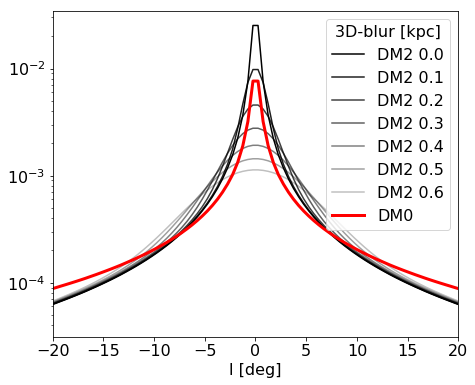

In [260]:
# plotting the profiles along lon and lat for all smoothing values
plt.figure(figsize=(16,6))
plt.subplot(121)
for i in tqdm(range(len(blur_scale_arr_nfw))):
    plt.plot(l,nfw12_arr[npc,:,i],label='DM2 '+str(round(blur_scale_arr_nfw[i],2)),
            color='black',alpha=(8-i)/8)
plt.plot(l,nfw0_tmp[npc,:],label='DM0',color='red',linewidth=3)
#plt.semilogy(l,bb_interp_blur_normed[npc,:]/np.amax(bb_interp_blur_normed),color='red',label='blurred interpolated')
plt.xlabel('l [deg]')
plt.xlim(-20,20)
#plt.xscale('symlog')
plt.yscale('log')
plt.legend(loc=1,title='3D-blur [kpc]')
plt.savefig('NFW_blur3D.pdf')
"""
plt.subplot(122)
for i in tqdm(range(len(blur_scale_arr_nfw))):
    plt.plot(l,nfw12_arr[:,npc,i],label='DM2 '+str(round(blur_scale_arr_nfw[i],2)),
            color='black',alpha=(8-i)/8)
plt.plot(l,nfw0_tmp[:,npc],label='DM0',color='red',linewidth=3)
#plt.semilogy(b,bb_interp_blur_normed[:,npc]/np.amax(bb_interp_blur_normed),color='red',label='blurred interpolated')
plt.xlabel('b [deg]')
plt.xlim(-20,20)
plt.legend(loc=1,title='3D-blur [kpc]')"""

In [186]:
nb_arr = np.zeros((n_pixels,n_pixels,len(blur_scale_arr)))
bb_arr = np.zeros((n_pixels,n_pixels,len(blur_scale_arr)))

In [187]:
for i in range(len(blur_scale_arr)):
    with fits.open('bulge_maps/Stellar_profile_Normalized_3D_smoothfactor_'+str('%02i' % i)+'.fits') as file:
        nb_arr[:,:,i] = file[0].data
    with fits.open('bulge_maps/Boxy_Bulge_50x50deg_Normalized_3D_smoothfactor_'+str('%02i' % i)+'.fits') as file:
        bb_arr[:,:,i] = file[0].data

In [230]:
with fits.open('/Users/thomassiegert/data/SPI/IG_maps/DMprofile_gamma1p0_50x50deg_Normalized.fits') as file:
        nfw00 = file[0].data

In [231]:
nfw00.shape

(100, 100)

In [203]:
nb2bb6 = np.array([0.71,0.45,0.31,0.34])

In [204]:
nb2bb6.mean()

0.4525

In [209]:
dm0_vals = np.array([0.4273,0.2692,0.2833,2.0683])
dm0_errs = np.array([0.0276,0.0253,0.0300,0.1604])

dm0_mean = np.sum(dm0_vals/dm0_errs**2)/np.sum(1/dm0_errs**2)
dm0_mean_err = 1/np.sum(1/dm0_errs**2)

In [210]:
dm0_mean,dm0_mean_err

(0.3420295610069889, 0.00024844666453901625)

In [242]:
blur_scale_arr_nfw

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

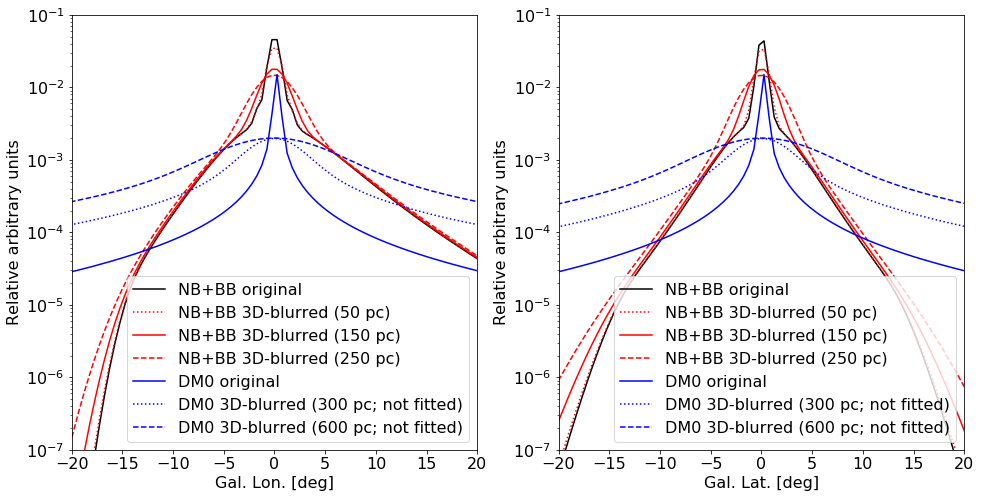

In [277]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.semilogy(l,smooth(nb_arr[npc,:,0]*0.2015+bb_arr[npc,:,0],0.5),label='NB+BB original')
plt.semilogy(l,smooth(nb_arr[npc,:,2]*0.2218+bb_arr[npc,:,2],0.5),color='red',label='NB+BB 3D-blurred (50 pc)',linestyle=':')
plt.semilogy(l,smooth(nb_arr[npc,:,6]*0.3737+bb_arr[npc,:,6],0.5),color='red',label='NB+BB 3D-blurred (150 pc)')
plt.semilogy(l,smooth(nb_arr[npc,:,10]*0.7270+bb_arr[npc,:,10],0.5),color='red',label='NB+BB 3D-blurred (250 pc)',linestyle='--')
plt.semilogy(l,smooth(nfw00[npc,:],0.5)*1.2015*0.3420*1e-4,color='blue',label='DM0 original')
#plt.semilogy(l,smooth(nfw10_arr[npc,:,0],0.5)*1.2015*0.3420*3.5,color='blue',label='DM0 original')
plt.semilogy(l,smooth(nfw10_arr[npc,:,3],0.5)*1.2015*0.3420*3.5,color='blue',label='DM0 3D-blurred (300 pc; not fitted)',linestyle=':')
plt.semilogy(l,smooth(nfw10_arr[npc,:,6],0.5)*1.2015*0.3420*7,color='blue',label='DM0 3D-blurred (600 pc; not fitted)',linestyle='--')
plt.ylim(1e-7,0.1)
plt.xlim(-20,20)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Relative arbitrary units')
plt.legend()

plt.subplot(122)
plt.semilogy(b,smooth(nb_arr[:,npc,0]*0.2015+bb_arr[:,npc,0],0.5),label='NB+BB original')
plt.semilogy(l,smooth(nb_arr[:,npc,2]*0.2218+bb_arr[:,npc,2],0.5),color='red',label='NB+BB 3D-blurred (50 pc)',linestyle=':')
plt.semilogy(b,smooth(nb_arr[:,npc,6]*0.3737+bb_arr[:,npc,6],0.5),color='red',label='NB+BB 3D-blurred (150 pc)')
plt.semilogy(l,smooth(nb_arr[:,npc,10]*0.7270+bb_arr[:,npc,10],0.5),color='red',label='NB+BB 3D-blurred (250 pc)',linestyle='--')
#plt.semilogy(b,smooth(nfw10_arr[:,npc,0],0.5)*1.2015*0.3420*3.5,color='blue',label='DM0 original')
plt.semilogy(l,smooth(nfw00[:,npc],0.5)*1.2015*0.3420*1e-4,color='blue',label='DM0 original')
plt.semilogy(l,smooth(nfw10_arr[:,npc,3],0.5)*1.2015*0.3420*3.5,color='blue',label='DM0 3D-blurred (300 pc; not fitted)',linestyle=':')
plt.semilogy(l,smooth(nfw10_arr[:,npc,6],0.5)*1.2015*0.3420*7,color='blue',label='DM0 3D-blurred (600 pc; not fitted)',linestyle='--')
plt.ylim(1e-7,0.1)
plt.xlim(-20,20)
plt.xlabel('Gal. Lat. [deg]')
plt.ylabel('Relative arbitrary units')
plt.legend()

plt.savefig('SPI_fitted_3Dblurred_bulge_profiles.pdf')

<h5>Additional functions</h5>

In [716]:
# define 3D Gaussian in s,l,b and x,y,z, parametrised
@jit(nopython=True)
def Gauss3Dgal_par(s,b,l,phi,theta,Rscl,hscl):
    x0 = 8.5
    y0 = 0
    z0 = 0.017
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    phi = phi*deg2rad
    theta = theta*deg2rad
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp2 = xp**2+yp**2
    return exp(-0.5*(Rp2/Rscl**2 + (zp/hscl)**2))

In [717]:
@jit(nopython=True)
def Gauss3Dxyz_par(x,y,z,phi,theta,Rscl,hscl):
    phi = phi*deg2rad
    theta = theta*deg2rad
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp2 = xp**2+yp**2 
    return exp(-0.5*(Rp2/Rscl**2 + (zp/hscl)**2))

In [718]:
Rscl = 0.05
hscl = 0.02
phi = 0
theta = 30
values_nb = np.vectorize(Gauss3Dxyz_par)(xx,yy,zz,phi,theta,Rscl,hscl)
values_nb.shape
values_nb_interp = RegularGridInterpolator((x,y,z), values_nb, method='linear',bounds_error=False, fill_value=0)
new_values_nb = values_nb_interp(xi).reshape(grid_s.shape)
los_new_nb = cos(deg2rad*grid_b)*(new_values_nb) 
nb_interp = np.sum(los_new_nb*ds,axis=0)
nb_interp_normed = nb_interp / np.sum(nb_interp*domega) # normalise to 1

Text(0.5, 1.0, 'NB test: black = true, red = test')

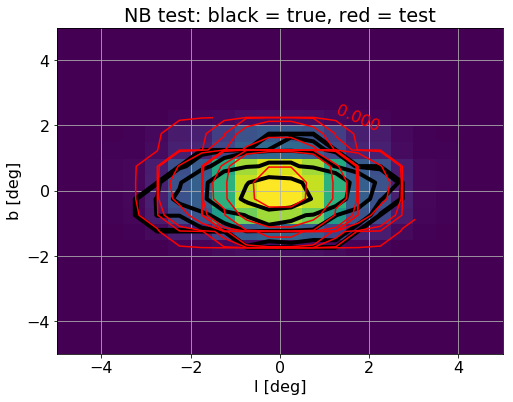

In [719]:
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,nb_interp_normed,
               norm=colors.PowerNorm(0.1,vmin=nb_interp_normed.min(),vmax=nb_interp_normed.max()))
# power norm index 0.1 to compare the outskirts



cs2 = plt.contour(l,b,nb_ts,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

cs1 = plt.contour(l,b,nb_interp_normed,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='red')
plt.clabel(cs1,cs1.levels)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('NB test: black = true, red = test')

In [720]:
# define 3D sphere in s,l,b and x,y,z, parametrised
@jit(nopython=True)
def Sphere3Dgal_par(s,b,l,phi,theta,R0):
    x0 = 8.5
    y0 = 0
    z0 = 0.017
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    phi = phi*deg2rad
    theta = theta*deg2rad
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp2 = xp**2+yp**2+zp**2
    if Rp2 <= R0**2:
        return 1.
    else:
        return 0.

In [721]:
# define 3D sphere in s,l,b and x,y,z, parametrised
@jit(nopython=True)
def Sphere3Dxyz_par(x,y,z,phi,theta,R0):
    x0 = 8.5
    y0 = 0
    z0 = 0.017
    phi = phi*deg2rad
    theta = theta*deg2rad
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp2 = xp**2+yp**2+zp**2
    if Rp2 <= R0**2:
        return 1.
    else:
        return 0.

In [722]:
R0 = 0.5
phi = 0
theta = 0
values_sph = np.vectorize(Sphere3Dxyz_par)(xx,yy,zz,phi,theta,R0)
values_sph.shape
values_sph_interp = RegularGridInterpolator((x,y,z), values_sph, method='linear',bounds_error=False, fill_value=0)
new_values_sph = values_sph_interp(xi).reshape(grid_s.shape)
los_new_sph = cos(deg2rad*grid_b)*(new_values_sph) 
sph_interp = np.sum(los_new_sph*ds,axis=0)
sph_interp_normed = sph_interp / np.sum(sph_interp*domega) # normalise to 1

Text(0.5, 1.0, 'sph test')

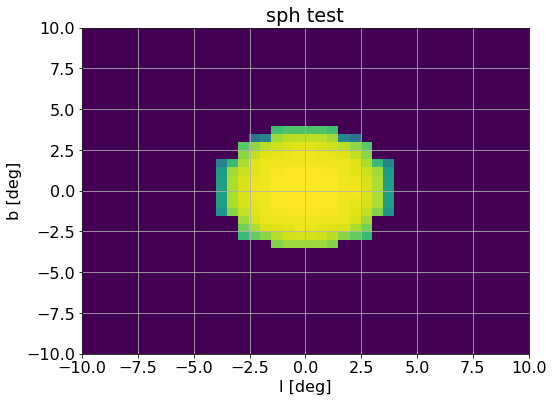

In [723]:
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,sph_interp_normed,
               norm=colors.PowerNorm(0.1,vmin=sph_interp_normed.min(),vmax=sph_interp_normed.max()))
# power norm index 0.1 to compare the outskirts



#cs2 = plt.contour(l,b,sph_interp_normed,
#                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
#plt.clabel(cs2,cs2.levels)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('sph test')

In [724]:
# define 3D ellipsoid in s,l,b and x,y,z, parametrised
@jit(nopython=True)
def Ellipsoid3Dgal_par(s,b,l,phi,theta,a0,b0,c0):
    x0 = 8.5
    y0 = 0
    z0 = 0.017
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    phi = phi*deg2rad
    theta = theta*deg2rad
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp2 = (xp/a0)**2+(yp/b0)**2+(zp/c0)**2
    if Rp2 <= 1:
        return 1.
    else:
        return 0.

In [725]:
# define 3D sphere in s,l,b and x,y,z, parametrised
@jit(nopython=True)
def Ellipsoid3Dxyz_par(x,y,z,phi,theta,a0,b0,c0):
    x0 = 8.5
    y0 = 0
    z0 = 0.017
    phi = phi*deg2rad
    theta = theta*deg2rad
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    Rp2 = (xp/a0)**2+(yp/b0)**2+(zp/c0)**2
    if Rp2 <= 1:
        return 1.
    else:
        return 0.

In [726]:
a0,b0,c0 = 0.25,0.35,0.2
phi = 0
theta = 25
values_ell = np.vectorize(Ellipsoid3Dxyz_par)(xx,yy,zz,phi,theta,a0,b0,c0)
values_ell.shape
values_ell_interp = RegularGridInterpolator((x,y,z), values_ell, method='linear',bounds_error=False, fill_value=0)
new_values_ell = values_ell_interp(xi).reshape(grid_s.shape)
los_new_ell = cos(deg2rad*grid_b)*(new_values_ell) 
ell_interp = np.sum(los_new_ell*ds,axis=0)
ell_interp_normed = ell_interp / np.sum(ell_interp*domega) # normalise to 1

Text(0.5, 1.0, 'ell test')

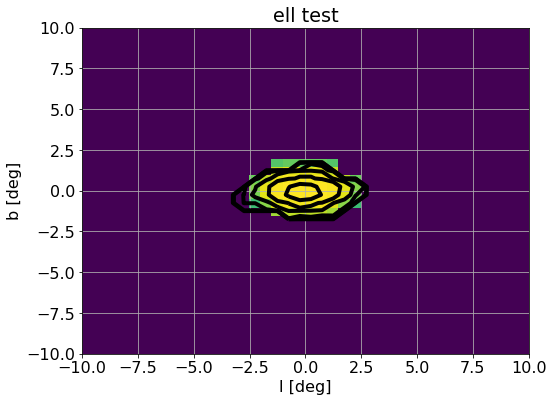

In [727]:
# compare contours
plt.pcolormesh(L_ARRg,B_ARRg,ell_interp_normed,
               norm=colors.PowerNorm(0.1,vmin=ell_interp_normed.min(),vmax=ell_interp_normed.max()))
# power norm index 0.1 to compare the outskirts



#cs2 = plt.contour(l,b,sph_interp_normed,
#                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
#plt.clabel(cs2,cs2.levels)

cs2 = plt.contour(l,b,nb_ts,
                  levels=[1e-9,1e-5,1e-4,0.001,0.01,0.1,1,10,100,1000],colors='black',linewidths=4)
plt.clabel(cs2,cs2.levels)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.grid()
plt.title('ell test')

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


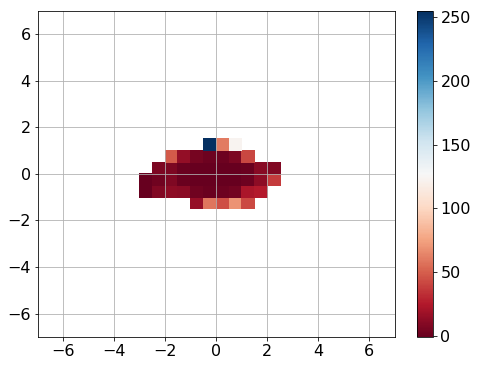

In [729]:
plt.pcolormesh(L_ARRg,B_ARRg,(ell_interp_normed*1e-4-nb_ts)/nb_ts,cmap=plt.cm.RdBu)
plt.colorbar()
plt.xlim(-7,7)
plt.ylim(-7,7)
plt.grid()

(-5, 5)

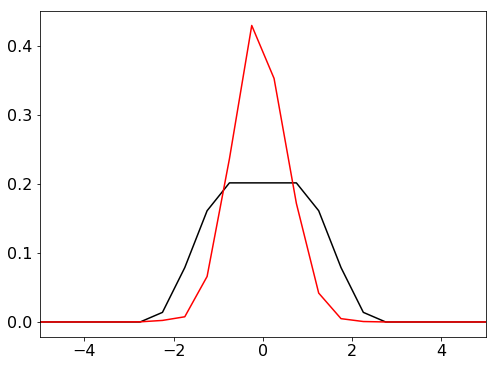

In [730]:
plt.plot(l,np.sum(ell_interp_normed*1e-4,axis=0))
plt.plot(l,np.sum(nb_ts,axis=0))
plt.xlim(-5,5)

In [731]:
np.sum(ell_interp_normed*domega)

0.9999999999999999

In [732]:
np.sum(nb_ts*domega)

0.00010000000000000002